In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from jupyter_dash import JupyterDash
from dash import dcc, html, State
from dash.dependencies import Input, Output
import plotly.express as px  

from dash import dash_table

app = JupyterDash(__name__)

In [28]:
df = pd.read_csv('../Sentiment & Engagement Datasets/ready_data_score.csv')

In [29]:
df.head(2)

,text,title,author,num_comments,post_id,upvote_ratio,score,url,subreddit,link_flair_text,link_flair_template_id,created_datetime,day_of_week,hour_of_day,month,year,sentiment_score
0,Hi context year old guy Amsterdam currently em...,Lazy job or Hard job?,Weak_Assumption_6889,8,1bfpxll,0.33,0,https://www.reddit.com/r/careeradvice/comments...,careeradvice,Unknown,Unknown,2024-03-15 22:07:22,Friday,22,March,2024,0.7579
1,Looking new role havenut much traction Recentl...,Roast my Resume Pls,Neither_Trash,1,1bh8md2,0.99,1,https://i.redd.it/n918fjprlyoc1.jpeg,resumes,Review my resume • I'm in North America,c292b8e0-28b9-11ec-874c-325b17e851a3,2024-03-17 21:05:40,Sunday,21,March,2024,0.6369


Goal: to understand how different communities or topics drive user interaction. 

we'll focus on the following features: subreddit, link_flair_text (flairs), and engagement metrics (num_comments, score, upvote_ratio).

### Getting Data Ready

In [4]:
### check the engagement metrics first

engagement_summary = df[['num_comments', 'score', 'upvote_ratio']].describe()
print(engagement_summary)

       num_comments         score  upvote_ratio
count   7760.000000   7760.000000   7760.000000
mean      64.038273    303.520232      0.799326
std      264.504485   1594.499721      0.227588
min        0.000000      0.000000      0.050000
25%        1.000000      1.000000      0.670000
50%        4.000000      1.000000      0.900000
75%       15.000000      7.000000      1.000000
max     8325.000000  43206.000000      1.000000


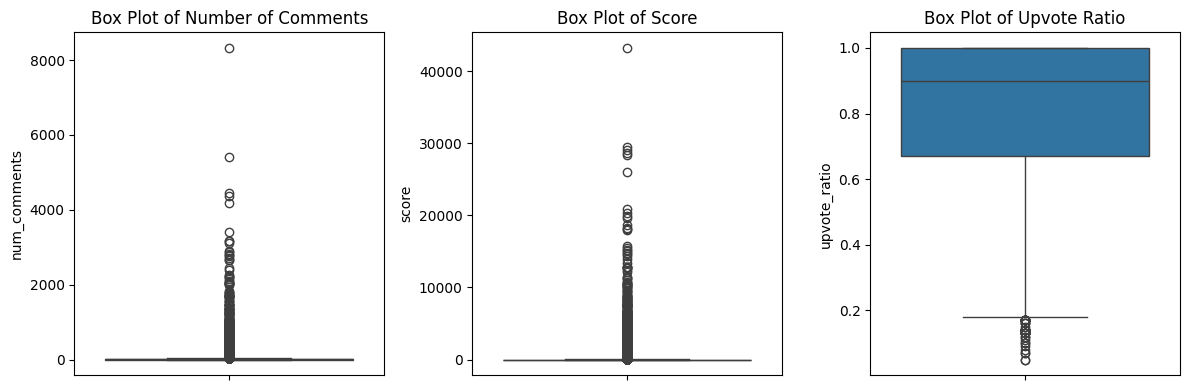

In [5]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['num_comments'])
plt.title('Box Plot of Number of Comments')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['score'])
plt.title('Box Plot of Score')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['upvote_ratio'])
plt.title('Box Plot of Upvote Ratio')

plt.tight_layout()
plt.show()



In [6]:
# Applying log transformation with an offset to avoid log(0)
df['log_num_comments'] = np.log1p(df['num_comments'])  # log(x + 1)
df['log_score'] = np.log1p(df['score'])


In [7]:
# Defining a function to detect outliers
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = ((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR)))
    return outlier_mask

# Apply the function to detect outliers for 'num_comments' and 'score'
df['outlier_num_comments'] = detect_outliers(df['num_comments'])
df['outlier_score'] = detect_outliers(df['score'])


In [8]:
## check subreddit. 
unique_subreddits = df['subreddit'].unique()
print(unique_subreddits)  


['careeradvice' 'resumes' 'ITCareerQuestions' 'FinancialCareers'
 'LegalAdviceOffTopic' 'teachers' 'AskHR' 'sales' 'careerguidance' 'jobs'
 'cscareerquestions' 'EngineeringCareers']


In [9]:
subreddit_counts = df['subreddit'].value_counts()
print(subreddit_counts)


subreddit
careeradvice           972
teachers               892
LegalAdviceOffTopic    888
ITCareerQuestions      855
FinancialCareers       770
careerguidance         681
jobs                   638
cscareerquestions      533
resumes                520
sales                  491
AskHR                  445
EngineeringCareers      75
Name: count, dtype: int64


In [10]:
# Filter out the 'EngineeringCareers' subreddit
df = df[df['subreddit'] != 'EngineeringCareers']


In [11]:
##check the link_flair_text

# Group the flairs by subreddit and list unique flairs in each
flairs_by_subreddit = df.groupby('subreddit')['link_flair_text'].unique()


In [12]:
for subreddit, flairs in flairs_by_subreddit.items():
    print(f"Subreddit: {subreddit}")
    print(f"Unique Flairs: {flairs}\n")


Subreddit: AskHR
Unique Flairs: ['Unknown' 'Policy & Procedures' 'Career Development' 'Workplace Issues'
 'Off Topic / Other' 'Employment Law' 'Compensation & Payroll'
 'Recruitment & Talent Acquisition' 'Employee Relations' 'Leaves'
 'California' 'Resignation/Termination' 'Performance Management'
 'Learning & Development' 'United States Specific' 'Benefits'
 'Unemployment' 'Canada' 'UK' 'Training' 'Risk Management'
 'Diversity & Inclusion' 'Recruitment' 'ANSWERED/RESOLVED']

Subreddit: FinancialCareers
Unique Flairs: ['Unknown' 'Breaking In' 'Profession Insights' 'Announcement'
 'Education & Certifications' 'Career Progression' 'Interview Advice'
 'Off Topic / Other' 'Tools and Resources' 'Networking' 'Resume Feedback'
 'Ask Me Anything' 'Skill Development']

Subreddit: ITCareerQuestions
Unique Flairs: ['Unknown' 'Seeking Advice' 'Early Career' 'Mid Career']

Subreddit: LegalAdviceOffTopic
Unique Flairs: ['Unknown' 'BestOf' 'Update']

Subreddit: careeradvice
Unique Flairs: ['Unknown']

### Categorizing Each Subreddit

In [13]:


# Define the flair categories for AskHR
flair_categories_askhr = {
    'Policy & Procedures': 'Policy & Legal',
    'Career Development': 'Career & Development',
    'Workplace Issues': 'Workplace Issues',
    'Off Topic / Other': 'Miscellaneous',
    'Employment Law': 'Policy & Legal',
    'Compensation & Payroll': 'Compensation & Benefits',
    'Recruitment & Talent Acquisition': 'Recruitment & Talent',
    'Employee Relations': 'Workplace Issues',
    'Leaves': 'Workplace Issues',
    'California': 'Policy & Legal',
    'Resignation/Termination': 'Workplace Issues',
    'Performance Management': 'Career & Development',
    'Learning & Development': 'Career & Development',
    'United States Specific': 'Policy & Legal',
    'Benefits': 'Compensation & Benefits',
    'Unemployment': 'Compensation & Benefits',
    'Canada': 'Policy & Legal',
    'UK': 'Policy & Legal',
    'Training': 'Career & Development',
    'Risk Management': 'Career & Development',
    'Diversity & Inclusion': 'Policy & Legal',
    'Unknown': 'Miscellaneous',
    np.nan: 'Miscellaneous',
    'Recruitment': 'Recruitment & Talent',
    'ANSWERED/RESOLVED': 'Miscellaneous'
}

# apply the mapping to the 'AskHR' subreddit
df['category_AskHR'] = df[df['subreddit'] == 'AskHR']['link_flair_text'].map(flair_categories_askhr)




In [14]:
# Define the flair categories for FinancialCareers
flair_categories_financialcareers = {
    'Unknown': 'Miscellaneous',
    'Breaking In': 'Career Development',
    'Profession Insights': 'Professional Insights',
    'Announcement': 'Miscellaneous',
    'Education & Certifications': 'Educational Resources',
    'Career Progression': 'Career Development',
    'Interview Advice': 'Career Development',
    'Off Topic / Other': 'Miscellaneous',
    'Tools and Resources': 'Educational Resources',
    'Networking': 'Professional Insights',
    'Resume Feedback': 'Career Development',
    'Ask Me Anything': 'Career Development',
    'Skill Development': 'Career Development',
    np.nan: 'Miscellaneous'
}

# Apply the mapping to the 'FinancialCareers' subreddit
df['category_FinancialCareers'] = df[df['subreddit'] == 'FinancialCareers']['link_flair_text'].map(flair_categories_financialcareers)


In [15]:
# Define the flair categories for ITCareerQuestions
flair_categories_itcareerquestions = {
    'Unknown': 'Miscellaneous',
    'Seeking Advice': 'Advice',
    'Early Career': 'Career Stage',
    'Mid Career': 'Career Stage',
    np.nan: 'Miscellaneous'
}

# Apply the mapping to the 'ITCareerQuestions' subreddit
df['category_ITCareerQuestions'] = df[df['subreddit'] == 'ITCareerQuestions']['link_flair_text'].map(flair_categories_itcareerquestions)


In [16]:
# Define the flair categories for LegalAdviceOffTopic
flair_categories_legaladviceofftopic = {
    'Unknown': 'Miscellaneous',
    'BestOf': 'Highlight',
    'Update': 'Updates & Follow-ups',
    np.nan: 'Miscellaneous'
}

# Apply the mapping to the 'LegalAdviceOffTopic' subreddit
df['category_LegalAdviceOffTopic'] = df[df['subreddit'] == 'LegalAdviceOffTopic']['link_flair_text'].map(flair_categories_legaladviceofftopic)


In [17]:
# Define the flair categories for careeradvice
flair_categories_careeradvice = {
    'Unknown': 'General Advice',
    np.nan: 'General Advice'
}

# Apply the mapping to the 'careeradvice' subreddit
df['category_careeradvice'] = df[df['subreddit'] == 'careeradvice']['link_flair_text'].map(flair_categories_careeradvice)


In [18]:
# Define the flair categories for careerguidance
flair_categories_careerguidance = {
    'Unknown': 'General Advice',
    'Advice': 'General Advice',
    'Education & Qualifications': 'Education & Certification',
    'Europe': 'Geographical',
    'India': 'Geographical',
    'United States': 'Geographical',
    'Canada': 'Geographical',
    'The Netherlands': 'Geographical',
    'Netherlands': 'Geographical',
    'USA': 'Geographical',
    'Maryland': 'Geographical',
    'Australia': 'Geographical',
    'South Carolina': 'Geographical',
    'Germany': 'Geographical',
    'Detroit,Michigan': 'Geographical',
    'USA remote': 'Geographical',
    'Edit with your location-Pakistan ': 'Geographical',
    'Edit with your location': 'Geographical',
    'Resumes & CVs': 'Resume Advice',
    'Coworkers': 'Workplace Dynamics',
    np.nan: 'General Advice'
}

# Apply the mapping to the 'careerguidance' subreddit
df['category_careerguidance'] = df[df['subreddit'] == 'careerguidance']['link_flair_text'].map(flair_categories_careerguidance)


In [19]:
# Define the flair categories for cscareerquestions
flair_categories_cscareerquestions = {
    'Unknown': 'General Advice & Questions',
    'New Grad': 'Career Stage',
    'Experienced': 'Career Stage',
    'Student': 'Career Stage',
    'Meta': 'General Advice & Questions',
    'Lead/Manager': 'Career Stage',
    'Keep it civil!': 'General Advice & Questions',
    np.nan: 'Miscellaneous'
}

# Apply the mapping to the 'cscareerquestions' subreddit
df['category_cscareerquestions'] = df[df['subreddit'] == 'cscareerquestions']['link_flair_text'].map(flair_categories_cscareerquestions)


In [20]:
# Define the flair categories for jobs
flair_categories_jobs = {
    'Applications': 'Job Search Process',
    'Weekly Megathread': 'Resources & Networking',
    'Discipline': 'Workplace Dynamics & Issues',
    'Post-interview': 'Job Search Process',
    'Job searching': 'Job Search Process',
    'Interviews': 'Job Search Process',
    'Onboarding': 'Job Search Process',
    'Leaving a job': 'Workplace Dynamics & Issues',
    'Unemployment': 'Workplace Dynamics & Issues',
    'Contract work': 'Workplace Dynamics & Issues',
    'Promotions': 'Career Development & Planning',
    'Office relations': 'Workplace Dynamics & Issues',
    'Career planning': 'Career Development & Planning',
    'Qualifications': 'Career Development & Planning',
    'Recruiters': 'Resources & Networking',
    'Internships': 'Resources & Networking',
    'Networking': 'Resources & Networking',
    'Resumes/CVs': 'Resources & Networking',
    'Rejections': 'Job Search Process',
    'Unknown': 'Miscellaneous',
    'Career development': 'Career Development & Planning',
    'Work/Life balance': 'Career Development & Planning',
    ' HR ': 'Workplace Dynamics & Issues',
    'Temp work': 'Workplace Dynamics & Issues',
    'References': 'Resources & Networking',
    'Training': 'Career Development & Planning',
    'Article': 'Resources & Networking',
    'Layoffs': 'Workplace Dynamics & Issues',
    'Compensation': 'Compensation & Benefits',
    'Companies': 'Compensation & Benefits',
    'Education': 'Career Development & Planning',
    'Evaluations': 'Compensation & Benefits',
    np.nan: 'Miscellaneous',
    'Job offers': 'Job Search Process'
}

# Apply the mapping to the 'jobs' subreddit
df['category_jobs'] = df[df['subreddit'] == 'jobs']['link_flair_text'].map(flair_categories_jobs)


In [21]:
# Define the flair categories for resumes
flair_categories_resumes = {
    "Review my resume • I'm in North America": "Resume Review by Region",
    "Review my resume • I'm in Asia": "Resume Review by Region",
    "Review my resume • I'm in Europe": "Resume Review by Region",
    "Review my resume • I'm in Australia": "Resume Review by Region",
    "Review my resume • I'm in the Middle East": "Resume Review by Region",
    "Review my resume • I'm in South America": "Resume Review by Region",
    "Review my resume • I'm in Africa": "Resume Review by Region",
    'I need feedback - Asia ': "Resume Review by Region",
    'I need feedback - Middle East ': "Resume Review by Region",
    'I need feedback - North America ': "Resume Review by Region",
    'I need feedback - Australia ': "Resume Review by Region",
    'I have a general question': "General Questions & Advice",
    'Discussion': "General Questions & Advice",
    "I'm sharing advice": "General Questions & Advice",
    'I have a question': "General Questions & Advice",
    'Mod Announcement ': "Miscellaneous & Announcements",
    'Other': "Miscellaneous & Announcements",
    'Success Story': "Miscellaneous & Announcements",
    np.nan: "Miscellaneous & Announcements"
}

# Apply the mapping to the 'resumes' subreddit
df['category_resumes'] = df[df['subreddit'] == 'resumes']['link_flair_text'].map(flair_categories_resumes)


In [22]:
# Define the flair categories for sales
flair_categories_sales = {
    'Sales Topic General Discussion': 'General Discussion & Advice',
    'Sales Careers': 'Career Development',
    'Sales Leadership Focused': 'Leadership & Strategy',
    'Fundamental Sales Skills': 'Skills & Training',
    'Advanced Sales Skills': 'Skills & Training',
    'Sales Tools and Resources': 'Skills & Training',
    'Discussion': 'General Discussion & Advice',
    'Resource': 'Resources & Highlights',
    'Off-Topic': 'Miscellaneous',
    'Best of r/Sales': 'Resources & Highlights',
    'Career': 'Career Development',
    'Advice': 'General Discussion & Advice',
    'Shit Post': 'Miscellaneous',
    'Shitpost': 'Miscellaneous',
    'Question': 'General Discussion & Advice',
    'Sales Career Q&A': 'Career Development',
    np.nan: 'Miscellaneous'
}

# Apply the mapping to the 'sales' subreddit
df['category_sales'] = df[df['subreddit'] == 'sales']['link_flair_text'].map(flair_categories_sales)


In [23]:
# Define the flair categories for teachers
flair_categories_teachers = {
    'Teacher Support &/or Advice': 'Support & Advice',
    'Student Teacher Support &/or Advice': 'Support & Advice',
    'SUCCESS!': 'Community & Well-being',
    'Student or Parent': 'Specific Roles & Perspectives',
    'Career & Interview Advice': 'Support & Advice',
    'Power of Positivity': 'Community & Well-being',
    'Rant & Vent': 'Community & Well-being',
    'Humor': 'Community & Well-being',
    'Classroom Management & Strategies': 'Classroom & Teaching Strategies',
    "Just Smile and Nod Y'all.  ": 'Community & Well-being',
    'Policy & Politics': 'Policy & Professional Development',
    'Another AI / ChatGPT Post 🤖': 'Community & Well-being',
    'Curriculum': 'Classroom & Teaching Strategies',
    'New Teacher': 'Support & Advice',
    'Pedagogy & Best Practices': 'Classroom & Teaching Strategies',
    'Professional Dress & Wardrobe': 'Classroom & Teaching Strategies',
    'Higher Ed / PD / Cert Exams': 'Policy & Professional Development',
    'Charter or Private School': 'Policy & Professional Development',
    'COVID-19': 'Community & Well-being',
    'Substitute Teacher': 'Specific Roles & Perspectives',
    'Non-US Teacher': 'Specific Roles & Perspectives',
    'Retired Teacher': 'Specific Roles & Perspectives',
    'Bad Teacher, No Apple': 'Specific Roles & Perspectives',
    'RANT [Students/Parents]': 'Specific Roles & Perspectives',
    'Resignation': 'Specific Roles & Perspectives',
    np.nan: 'Miscellaneous'
}

# Apply the mapping to the 'teachers' subreddit
df['category_teachers'] = df[df['subreddit'] == 'teachers']['link_flair_text'].map(flair_categories_teachers)


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7685 entries, 0 to 7759
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   text                          7685 non-null   object 
 1   title                         7685 non-null   object 
 2   author                        7685 non-null   object 
 3   num_comments                  7685 non-null   int64  
 4   post_id                       7685 non-null   object 
 5   upvote_ratio                  7685 non-null   float64
 6   score                         7685 non-null   int64  
 7   url                           7685 non-null   object 
 8   subreddit                     7685 non-null   object 
 9   link_flair_text               7685 non-null   object 
 10  link_flair_template_id        7685 non-null   object 
 11  created_datetime              7685 non-null   object 
 12  day_of_week                   7685 non-null   object 
 13  hour_of_

In [25]:
df.to_csv('../Sentiment & Engagement Datasets/subreddit_flair_data.csv')